# MACRO

In [1]:
import matplotlib.pyplot as plt

In [2]:
from IPython.core.debugger import set_trace

In [3]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
mdata = sm.datasets.macrodata.load_pandas().data

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
df = pd.read_excel('Cours_singalmacro_hotelresto_final.xlsx')

In [5]:
df[:3]

,Dates,Cours,Signal macro
0,2015-10-01,174.388331,0
1,2015-10-02,176.600817,0
2,2015-10-05,180.076292,0


In [6]:
signal = df['Signal macro']
cours = df['Cours']

# MACD

In [7]:
def sma(n,debut,macd):
    
    
    myval = 0
    myval = np.mean(macd[debut-n:debut])
    return myval



In [8]:
def fema(n):
    p=2/(n+1)
    ema=[]
    for i in range(0,len(cours)):
        if i==0:
            ema.append(cours[0]*p)
        else:
            ema.append(cours[i]*p + ema[i-1]*(1-p))
    return ema    

In [9]:
def fmacd(court,long,jourmoy):
    emadouze=[]
    emavingtsix=[]
    emadouze=fema(court)
    emavingtsix=fema(long)
    macd=[]
    signal=[]
    
    for i in range(0,len(cours)):
        macd.append(emadouze[i]-emavingtsix[i])
    
    for j in range(jourmoy,len(cours)):
        signal.append(sma(jourmoy,j,macd))
    
    macd=macd[jourmoy-1:len(cours)]
    return signal,macd
    
    

In [10]:
def strategiemacd(court,long,jourmoy):
    
    macd=[]
    signal=[]
    position=[]
    mapos=0
    unsignal=0
    
    signal,macd=fmacd(court,long,jourmoy)
    
    for i in range(1,len(cours)-jourmoy):
        #Signal de vente croisement entre macd et signal
        if macd[i-1]>signal[i-1]:
            if macd[i]<signal[i]:
                unsignal=1
                position.append(-1)

        #Signal de vente croisement entre macd et 0            
        elif macd[i-1]>0:
            if macd[i]<0:
                unsignal=1
                position.append(-1)
                
                    
        #Signal d'achat coisement entre macd et signal   
        if macd[i-1]<signal[i-1]:
            if macd[i]>signal[i]:
                unsignal=1
                position.append(1)
                    
        #Signal d'achat coisement entre macd et 0   
        elif macd[i-1]<0:
            if macd[i]>0:
                unsignal=1
                position.append(1)
        if unsignal==0:
            position.append(0)
            
        unsignal=0
    
    return position    
    
    
    

In [11]:
def macd_for_AG(c_period, l_period, jourmoy):
    #strat = strategiemacd(c_period, l_period)
    return nouveau_backtesteur(strategiemacd(c_period, l_period,jourmoy), jourmoy)[0]

# WILLIAMS

In [14]:
def nouveau_backtesteur(position_entree,position_sortie, jourmoy):
    cours_local = cours[-len(position_entree)-jourmoy-1:]
    cours_local = cours_local.reset_index(drop=True)
    positionAchat = False
    positionVente = False
    i = 0
    cash = [0] * len(cours_local)
    cash[0] = 200
    achete = [0] * len(cours_local)
    vente = [0] * len(cours_local)
    vl = [0] * len(cours_local)
        
    def calculer_VL(i):
        ac = (cours_local[i] - achete[i] ) + achete[i]
        v = (vente[i] - cours_local[i] ) + vente[i]
        vl[i] = cash[i]
        #set_trace()
        if(positionAchat == True):
            vl[i] += ac
        if(positionVente == True):
            vl[i] += v
        
    def new_line(i):
        if(i>0):
            #set_trace()
            cash[i] = cash[i-1]
            achete[i] = achete[i-1]
            vente[i] = vente[i-1]
        calculer_VL(i)
        
    sur_le_marche = False
        
    for i in range(len(position_entree)):
        #print(i)
        if(sur_le_marche == False):
            if(position_entree[i] == 1): # ACHAT
                new_line(i)
                if(positionAchat == False):
                    if(cash[i] > cours_local[i]):
                        cash[i] -= cours_local[i]
                        achete[i] += cours_local[i]
                        positionAchat = True
                        sur_le_marche = True
                calculer_VL(i)
            elif(position_entree[i] == -1): # SHORT
                new_line(i)
                if(positionVente == False):
                    if(cash[i] > cours_local[i]):
                        cash[i] -= cours_local[i]
                        vente[i] += cours_local[i]
                        positionVente = True
                        sur_le_marche = True
                calculer_VL(i)
            else:
                new_line(i)
        else:
            if(position_sortie[i] == 1): # FERMER ORDRE VENTE
                new_line(i)
                if(positionVente == True):
                    cash[i] += (vente[i] - cours_local[i]) + vente[i]
                    vente[i] = 0
                    positionVente = False
                    sur_le_marche = False
                calculer_VL(i)
            elif(position_sortie[i] == -1): # FERMER ORDRE ACHAT
                new_line(i)
                if(positionAchat == True):
                    cash[i] += cours_local[i]
                    achete[i] = 0
                    positionAchat = False
                    sur_le_marche = False
                calculer_VL(i)
            else:
                new_line(i)
            
            
    def base_100(vl):
        formule = [0] * len(vl)
        formule[0] = 100
        #set_trace()
        for i in range(1, len(vl)):
            try:
                rendement = (vl[i] - vl[i-1])/vl[i-1]
            except Exception as e:
                rendement = 0
            formule[i] = (1+rendement)*formule[i-1]
        return formule

    df1 = {'cash': cash, 'acheté': achete, 'vendu': vente, 'VL': vl, 'Cours': cours_local, 'pos_entree': position_entree, 'pos_sortie': position_sortie}
    return base_100(vl[:-jourmoy-1]), base_100(cours_local[:-jourmoy-1]), pd.DataFrame(df1)

In [15]:
def williams(nb_jour, oscill_low, oscill_high):
    Williams_list = [0] * nb_jour
    DateDebut=nb_jour
    DateFin=len(cours)

    for i in range(DateDebut,DateFin):

        Cours_hotel=cours[i]

        Cours_hotel_Min=Cours_hotel
        Cours_hotel_Max=Cours_hotel

        for j in range(1,nb_jour):


            temp=cours[i-j]

            if temp > Cours_hotel_Max:
                Cours_hotel_Max=temp


            if temp<Cours_hotel_Min:
                Cours_hotel_Min=temp


        Williams = -100 * ((Cours_hotel_Max-Cours_hotel)/(Cours_hotel_Max-Cours_hotel_Min))
        Williams_list.append(Williams)

    Signal_Williams_list=[0] * nb_jour
    DateDebut_2=nb_jour - 1
    DateFin_2=len(cours)-1
    for i in range(DateDebut_2,DateFin_2):

        Williams_n1=Williams_list[i]
        Williams_n2=Williams_list[i+1]

        if Williams_n2>Williams_n1 and Williams_n2<oscill_high:

            Signal_Williams=1

        elif Williams_n2<Williams_n1 and Williams_n2>oscill_low:

            Signal_Williams=-1

        else:

            Signal_Williams=0

        Signal_Williams_list.append(Signal_Williams)
        
    return Signal_Williams_list

In [16]:
def williams_for_AG(nb_jour):
    #strat = strategiemacd(c_period, l_period)
    return nouveau_backtesteur(williams(nb_jour), nb_jour)[0]

 # STRATEGIE TOTAL AVEC VARIABLES MACRO

In [17]:
def meme_taille(signal,signal_macdd,signal_williamss):
    signal_macro = signal[-len(signal_macdd):] # modif faite ici
    
    signal_williams =signal_williamss[-len(signal_macro):]
    signal_macd = signal_macdd[-len(signal_macro):]
    return signal_macd, signal_williams, signal_macro.reset_index()['Signal macro']

In [18]:
def strategie_final(signal_macd,signal_williams,signal_macro):
    strategie_total = pd.DataFrame({'signal macro': signal_macro,
     'signal williams': signal_williams,
     'signal macd': signal_macd,
    'signal_entree': signal_macd,
    'signal_sortie':signal_macd
    }) 
    for i in range(0, len(signal_williams)):
        if(strategie_total['signal macro'][i]==1 and strategie_total['signal williams'][i]==1 ):
            strategie_total['signal_entree'][i]=1
        elif (strategie_total['signal macro'][i]== 0 and strategie_total['signal williams'][i]==1 ):
            strategie_total['signal_entree'][i]=1
        elif (strategie_total['signal macro'][i]== -1 and strategie_total['signal williams'][i]==1 ):
            strategie_total['signal_entree'][i]= 0
        elif (strategie_total['signal macro'][i]== 1 and strategie_total['signal williams'][i]==0 ):
            strategie_total['signal_entree'][i]= 0
        elif (strategie_total['signal macro'][i]== 0 and strategie_total['signal williams'][i]==0 ):
            strategie_total['signal_entree'][i]= 0
        elif (strategie_total['signal macro'][i]== -1 and strategie_total['signal williams'][i]==0 ):
            strategie_total['signal_entree'][i]= 0
        elif (strategie_total['signal macro'][i]== 1 and strategie_total['signal williams'][i]==-1 ):
            strategie_total['signal_entree'][i]= 0 # modifier ici au cas où
        elif (strategie_total['signal macro'][i]== 0 and strategie_total['signal williams'][i]==-1 ):
            strategie_total['signal_entree'][i]= -1
        elif (strategie_total['signal macro'][i]== -1 and strategie_total['signal williams'][i]==-1 ):
            strategie_total['signal_entree'][i]= -1
            #-----------------------
        if(strategie_total['signal macro'][i]==1 and strategie_total['signal macd'][i]==1 ):
            strategie_total['signal_sortie'][i]= 1
        elif(strategie_total['signal macro'][i]==0 and strategie_total['signal macd'][i]==1 ):
            strategie_total['signal_sortie'][i]= 1
        elif(strategie_total['signal macro'][i]==-1 and strategie_total['signal macd'][i]==1 ):
            strategie_total['signal_sortie'][i]= 0
        elif(strategie_total['signal macro'][i]==1 and strategie_total['signal macd'][i]==0 ):
            strategie_total['signal_sortie'][i]= 0 
        elif(strategie_total['signal macro'][i]==0 and strategie_total['signal macd'][i]==0 ):
            strategie_total['signal_sortie'][i]= 0
        elif(strategie_total['signal macro'][i]==-1 and strategie_total['signal macd'][i]==0 ):
            strategie_total['signal_sortie'][i]= 0
        elif(strategie_total['signal macro'][i]==1 and strategie_total['signal macd'][i]==-1 ):
            strategie_total['signal_sortie'][i]= 0 # modif ici
        elif(strategie_total['signal macro'][i]==0 and strategie_total['signal macd'][i]==-1 ):
            strategie_total['signal_sortie'][i]= -1 
        elif(strategie_total['signal macro'][i]==-1 and strategie_total['signal macd'][i]==-1 ):
            strategie_total['signal_sortie'][i]= -1
        
            #on a rajouter la macro pour confirmer le signal de vente 
        # macro = 1 and macd = 1 -> sortie = 1
        # macro = 1 and macd = 0 -> sortie = 0
        # macro = 1 and macd = -1 -> sortie = 0
        # macro = -1 and macd = 1 -> sortie = 0
        # macro = -1 and macd = 0 -> sortie = 0
        # macro = -1 and macd = -1 -> sortie = -1
        # macro = 0 and macd = 1 -> sortie = 1
        # macro = 0 and macd = 0 -> sortie = 0
        # macro = 0 and macd = -1 -> sortie = -1
            
    return strategie_total

In [19]:
def signal_for_AG(signal, court, long, jourmoy, nb_jour, oscill_low, oscill_high):
    a,b,c=meme_taille(signal,strategiemacd(court,long,jourmoy),williams(nb_jour, oscill_low, oscill_high))
    tableau = strategie_final(a,b,c)
    #print(tableau)
    return nouveau_backtesteur(tableau['signal_entree'],tableau['signal_sortie'],jourmoy)[0]

In [20]:
def signal_for_AG_courscent(signal, court, long, jourmoy, nb_jour, oscill_low, oscill_high):
    a,b,c=meme_taille(signal,strategiemacd(court,long,jourmoy),williams(nb_jour, oscill_low, oscill_high))
    tableau = strategie_final(a,b,c)
    #print(tableau)
    return nouveau_backtesteur(tableau['signal_entree'],tableau['signal_sortie'], jourmoy)

# STRATEGIE TOTALE SANS VARIABLE MACRO

In [23]:
def strategie_final_sans_macro(signal_macd,signal_williams,signal_macro):
    strategie_total = pd.DataFrame({'signal macro': signal_macro,
     'signal williams': signal_williams,
     'signal macd': signal_macd,
    'signal_entree': signal_williams,
    'signal_sortie':signal_macd
    }) 
    #ici le signal total ne tient compte que du signal macd et signal williams pas du signal macro pour le moment
    return strategie_total

In [24]:
def signal_sans_macro_for_AG(signal, court, long, jourmoy, nb_jour, oscill_low, oscill_high):
    a,b,c=meme_taille(signal,strategiemacd(court,long,jourmoy),williams(nb_jour, oscill_low, oscill_high))
    tableau = strategie_final_sans_macro(a,b,c)
    #print(tableau)
    return nouveau_backtesteur(tableau['signal_entree'],tableau['signal_sortie'], jourmoy)[0]

In [25]:
def signal_sans_macro_for_AG_courscent(signal, court, long, jourmoy, nb_jour, oscill_low, oscill_high):
    a,b,c=meme_taille(signal,strategiemacd(court,long,jourmoy),williams(nb_jour, oscill_low, oscill_high))
    tableau = strategie_final_sans_macro(a,b,c)
    #print(tableau)
    return nouveau_backtesteur(tableau['signal_entree'],tableau['signal_sortie'], jourmoy)

# Algo Génétique

In [28]:
from deap import base, creator, tools
import random
import numpy as np

In [29]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

In [30]:
class Test():
    court = 0
    long = 0
    jourmoy = 0
    nb_jour = 0
    oscill_low = 0
    oscill_high = 0
    
    @staticmethod
    def create_attribute():
        if(Test.court == 0):
            Test.court = random.randint(1,30)
            return Test.court
        if(Test.long == 0):
            Test.long = random.randint(Test.court,30)
            return Test.long
        if(Test.jourmoy == 0):
            Test.jourmoy = random.randint(2, 15)
            return Test.jourmoy
        if(Test.nb_jour == 0):
            Test.nb_jour = random.randint(14,20)
            return Test.nb_jour
        if(Test.oscill_low == 0):
            Test.oscill_low = random.randint(-50, -1)
            return Test.oscill_low
        if(Test.oscill_high == 0):
            Test.court = 0
            Test.long = 0
            Test.jourmoy = 0
            Test.nb_jour = 0
            Test.oscill_low = 0
            Test.oscill_high = 0
            return random.randint(-100, -50)

In [31]:
IND_SIZE = 10

toolbox = base.Toolbox()
toolbox.register("attribute", Test.create_attribute)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluate_individual à modifier lors de l'optimisation avec/sans macro

In [32]:
def evaluate_individual(individual):
    if(individual[0] > individual[1]):
        return -1, 1
    if(individual[2] == 0):
        return -1, 1
    # MODIFIER SIGNAL_SANS_MACRO_FOR_AG par SIGNAL_FOR_AG
    vl = signal_for_AG(signal, individual[0], individual[1], individual[2], individual[3], individual[4], individual[5])
    #-------------------------------
    perf = (vl[len(vl) - 1] - vl[0] ) / vl[0]
    perfs = []
    for i in range(1, len(vl) - 1):
        temp = (vl[i] - vl[i-1]) / vl[i-1]
        perfs.append(temp)
    vol = np.std(perfs) * np.sqrt(252)
    return perf, vol

# ---------------------------------------------------------------

In [33]:
def evaluate(individual):
    return sum(individual),

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_individual)

In [34]:
def main():
    pop = toolbox.population(n=10000)
    #print(pop)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 10

    # Evaluer la population entière
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):
        # Sélectionner la prochaine génération d'individu
        print(g)
        offspring = toolbox.select(pop, len(pop))
        # Clone les individus sélectionnés
        offspring = list(map(toolbox.clone, offspring))

        # Appliquer le croisement et la mutation sur la nouvelle génération
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluer les individus avec une fonction fitness invalide
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        try:
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
        except Exception as e:
            print(e)
            print(ind)
            print(fit)

        # La popoluation est entièrement remplacée par les enfants
        pop[:] = offspring

    return pop

# RESULTAT AVEC MACRO

In [35]:
a = main()

0
1
2
3
4
5
6
7
8
9


In [39]:
t = []
maxi = 0
for c,b in enumerate(a):
    try:
        temp = evaluate_individual(b)
    except Exception as e:
        print(c)
    if(maxi < temp[0]):
        maxi = temp[0]
        print(c, temp[0], temp[1])

0 0.4998678267708303 0.13945759148594886
19 0.49987766003009965 0.1391098930337368
21 0.5013957135266918 0.13541650849793288
35 0.5027663027256344 0.13881293535762615
48 0.5144558829498493 0.1329270864985793


# Plot Des deux optimisations séparées

In [35]:
vl_sans_macro_param_optimisees_macro, courscent, tab1 = signal_sans_macro_for_AG_courscent(signal, 19,  29,   3,  20,  -4, -51)

In [36]:
vl_avec_macro_param_optimisees_macro,courscent, tab2 = signal_for_AG_courscent(signal, 5,  27,   1,  17, -46, -91)

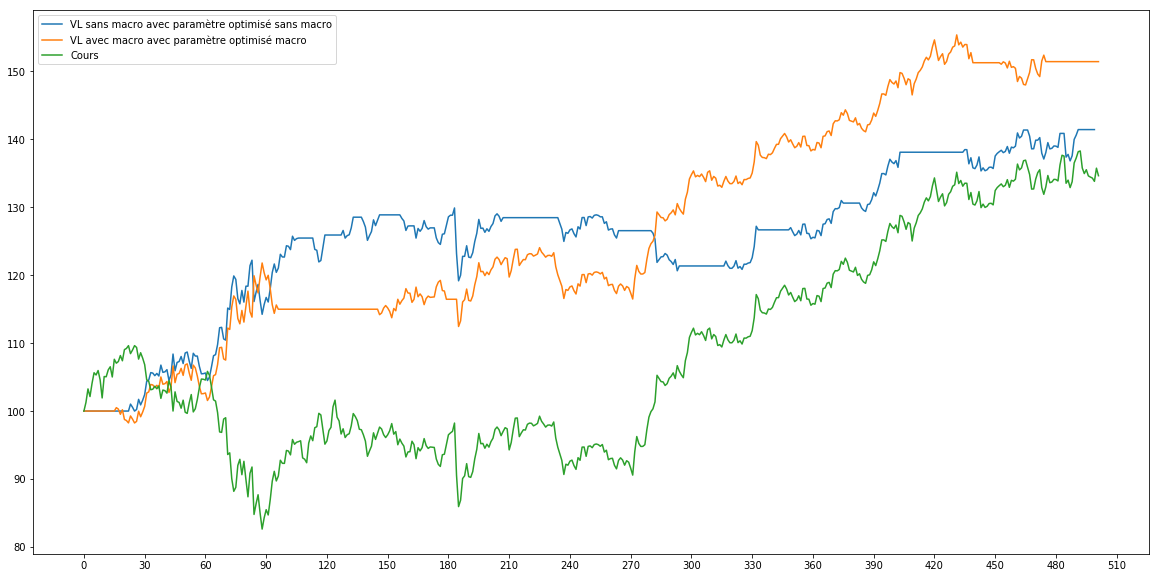

In [37]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0,600,30))
plt.plot(vl_sans_macro_param_optimisees_macro, label='VL sans macro avec paramètre optimisé sans macro')
plt.plot(vl_avec_macro_param_optimisees_macro, label='VL avec macro avec paramètre optimisé macro')
plt.plot(courscent, label='Cours')
plt.legend()
plt.show()

# ------------------------------------------

# Quelques chiffres

In [38]:
def get_perf(vl):
    perfs = []
    for i in range(1, len(vl)):
        rendement = (vl[i] - vl[i-1])/vl[i-1]
        perfs.append(rendement)
    return perfs

def vol_annuel(vl):
    perf = get_perf(vl)
    return np.std(perf) * np.sqrt(252)

def get_perf_annuel(vl):
    perf = get_perf(vl)
    perf_periode = (vl[len(perf)-1] - vl[0] ) / vl[0]
    perf_quotidienne = (1 + perf_periode) ** (1/len(vl)) -1
    perf_annuelle = (1 + perf_quotidienne) ** 365 -1
    return perf_annuelle

In [39]:
def max_drawdown(vl):
    max_dd = 0
    for i in range(len(vl) - 1):
        for j in range(i + 1, len(vl)):
            perf = (vl[j] - vl[i] ) / vl[i]
            if(perf < max_dd):
                max_dd = perf
    return max_dd

In [40]:
def ratio_sharpe(vl):
    return (get_perf_annuel(vl) - 0.01) / vol_annuel(vl)

In [41]:
vol = [vol_annuel(vl_sans_macro_param_optimisees_macro), vol_annuel(vl_avec_macro_param_optimisees_macro), vol_annuel(courscent)]

In [42]:
max_dd = [max_drawdown(vl_sans_macro_param_optimisees_macro), max_drawdown(vl_avec_macro_param_optimisees_macro), max_drawdown(courscent)]
max_dd = list(map(lambda x: -x, max_dd))

In [43]:
perfs = [get_perf_annuel(vl_sans_macro_param_optimisees_macro), get_perf_annuel(vl_avec_macro_param_optimisees_macro), get_perf_annuel(courscent)]

In [44]:
RS = [ratio_sharpe(vl_sans_macro_param_optimisees_macro), ratio_sharpe(vl_avec_macro_param_optimisees_macro), ratio_sharpe(courscent)]

In [45]:
index = ['Sans macro', 'Avec macro', 'Cours']

In [46]:
result = pd.DataFrame({'Performance annuelle': perfs, 'Volailité annuelle': vol, 'Max_drawdown': max_dd, 'Index': index, 'Ratio de Sharpe': RS})

In [47]:
result.set_index(['Index'])

,Max_drawdown,Performance annuelle,Ratio de Sharpe,Volailité annuelle
Index,,,,
Sans macro,0.082568,0.288008,2.126911,0.130710
Avec macro,0.076774,0.352269,2.577409,0.132796
Cours,0.246375,0.248918,1.115959,0.214092


# ------------------------------------------

# Sortie des tableaux de cash

In [48]:
cols = tab1.columns
cols = ['cash', 'acheté', 'vendu', 'VL', 'Cours', 'pos_entree', 'pos_sortie']
tab1 = tab1[cols]

In [49]:
tab1.to_csv('tableau_cash_sans_macro.csv')

In [50]:
cols = tab2.columns
cols = ['cash', 'acheté', 'vendu', 'VL', 'Cours', 'pos_entree', 'pos_sortie']
tab2 = tab2[cols]

In [51]:
tab2.to_csv('tableau_cash_avec_macro.csv')

# Sortie des tableaux de position

## a) Tableau avec macro

In [54]:
a,b,c=meme_taille(signal,strategiemacd(5,27,1),williams(17, -46, -91))
tableau_avec_macro = strategie_final(a,b,c)

In [55]:
tableau_avec_macro.to_csv('tableau_signaux_avec_macro.csv')

## b) Tableau sans macro

In [56]:
a,b,c=meme_taille(signal,strategiemacd(19,29,3),williams(20, -4, -51))
tableau_sans_macro = strategie_final_sans_macro(a,b,c)

In [57]:
tableau_sans_macro.to_csv('tableau_signaux_sans_macro.csv')